# FAST AI - Computer Vision - Image Classification

In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 5.6 MB/s 
     |████████████████████████████████| 4.7 MB 40.5 MB/s 
     |████████████████████████████████| 1.3 MB 56.8 MB/s 
     |████████████████████████████████| 365 kB 48.7 MB/s 
     |████████████████████████████████| 120 kB 57.5 MB/s 
     |████████████████████████████████| 212 kB 51.9 MB/s 
     |████████████████████████████████| 115 kB 49.8 MB/s 
     |████████████████████████████████| 127 kB 54.9 MB/s 
     |████████████████████████████████| 6.6 MB 35.2 MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *

## From Dogs and Cats to Pet Breeds

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

Now if we are going to understand how to extract the breed of each pet from each image we're going to need to understand how this data is laid out. Such details of data layout are a vital piece of the deep learning puzzle. Data is usually provided in one of these two ways:

- Individual files representing items of data, such as text documents or images, possibly organized into folders or with filenames representing information about those items
- A table of data, such as in CSV format, where each row is an item which may include filenames providing a connection between the data in the table and data in other formats, such as text documents and images

There are exceptions to these rules—particularly in domains such as genomics, where there can be binary database formats or even network streams—but overall the vast majority of the datasets you'll work with will use some combination of these two formats.

To see what is in our dataset we can use the `ls` method:

In [4]:
#hide
Path.BASE_PATH = path

In [5]:
path.ls()

(#2) [Path('annotations'),Path('images')]

We can see that this dataset provides us with *images* and *annotations* directories. The [website](https://www.robots.ox.ac.uk/~vgg/data/pets/) for the dataset tells us that the *annotations* directory contains information about where the pets are rather than what they are. In this chapter, we will be doing classification, not localization, which is to say that we care about what the pets are, not where they are. Therefore, we will ignore the *annotations* directory for now. So, let's have a look inside the *images* directory:

In [6]:
(path/"images").ls()

(#7393) [Path('images/Ragdoll_139.jpg'),Path('images/english_setter_194.jpg'),Path('images/Maine_Coon_266.jpg'),Path('images/Abyssinian_217.jpg'),Path('images/pug_171.jpg'),Path('images/shiba_inu_89.jpg'),Path('images/shiba_inu_81.jpg'),Path('images/great_pyrenees_30.jpg'),Path('images/samoyed_48.jpg'),Path('images/saint_bernard_140.jpg')...]

Most functions and methods in fastai that return a collection use a class called `L`. `L` can be thought of as an enhanced version of the ordinary Python `list` type, with added conveniences for common operations. For instance, when we display an object of this class in a notebook it appears in the format shown there. The first thing that is shown is the number of items in the collection, prefixed with a `#`. You'll also see in the preceding output that the list is suffixed with an ellipsis. This means that only the first few items are displayed—which is a good thing, because we would not want more than 7,000 filenames on our screen!

By examining these filenames, we can see how they appear to be structured. Each filename contains the pet breed, and then an underscore (`_`), a number, and finally the file extension. We need to create a piece of code that extracts the breed from a single `Path`. Jupyter notebooks make this easy, because we can gradually build up something that works, and then use it for the entire dataset. We do have to be careful to not make too many assumptions at this point. For instance, if you look carefully you may notice that some of the pet breeds contain multiple words, so we cannot simply break at the first `_` character that we find. To allow us to test our code, let's pick out one of these filenames:

In [7]:
fname = (path/"images").ls()[0]

The most powerful and flexible way to extract information from strings like this is to use a *regular expression*, also known as a *regex*. A regular expression is a special string, written in the regular expression language, which specifies a general rule for deciding if another string passes a test (i.e., "matches" the regular expression), and also possibly for plucking a particular part or parts out of that other string. 

When you are writing a regular expression, the best way to start is just to try it against one example at first. Let's use the `findall` method to try a regular expression against the filename of the `fname` object:

In [8]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['Ragdoll']

This regular expression plucks out all the characters leading up to the last underscore character, as long as the subsequence characters are numerical digits and then the JPEG file extension.

Now that we confirmed the regular expression works for the example, let's use it to label the whole dataset. fastai comes with many classes to help with labeling. For labeling with regular expressions, we can use the `RegexLabeller` class. In this example we use the data block API we saw in <<chapter_production>> (in fact, we nearly always use the data block API—it's so much more flexible than the simple factory methods we saw in <<chapter_intro>>):

In [9]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

One important piece of this `DataBlock` call that we haven't seen before is in these two lines:

```python
item_tfms=Resize(460),
batch_tfms=aug_transforms(size=224, min_scale=0.75)
```

These lines implement a fastai data augmentation strategy which we call *presizing*. Presizing is a particular way to do image augmentation that is designed to minimize data destruction while maintaining good performance.

## Presizing

We need our images to have the same dimensions, so that they can collate into tensors to be passed to the GPU. We also want to minimize the number of distinct augmentation computations we perform. The performance requirement suggests that we should, where possible, compose our augmentation transforms into fewer transforms (to reduce the number of computations and the number of lossy operations) and transform the images into uniform sizes (for more efficient processing on the GPU).

The challenge is that, if performed after resizing down to the augmented size, various common data augmentation transforms might introduce spurious empty zones, degrade data, or both. For instance, rotating an image by 45 degrees fills corner regions of the new bounds with emptiness, which will not teach the model anything. Many rotation and zooming operations will require interpolating to create pixels. These interpolated pixels are derived from the original image data but are still of lower quality.

To work around these challenges, presizing adopts two strategies that are shown in <<presizing>>:

1. Resize images to relatively "large" dimensions—that is, dimensions significantly larger than the target training dimensions. 
1. Compose all of the common augmentation operations (including a resize to the final target size) into one, and perform the combined operation on the GPU only once at the end of processing, rather than performing the operations individually and interpolating multiple times.

The first step, the resize, creates images large enough that they have spare margin to allow further augmentation transforms on their inner regions without creating empty zones. This transformation works by resizing to a square, using a large crop size. On the training set, the crop area is chosen randomly, and the size of the crop is selected to cover the entire width or height of the image, whichever is smaller.

In the second step, the GPU is used for all data augmentation, and all of the potentially destructive operations are done together, with a single interpolation at the end.

<img alt="Presizing on the training set" width="600" caption="Presizing on the training set" id="presizing" src="https://github.com/fastai/fastbook/blob/master/images/att_00060.png?raw=1">

This picture shows the two steps:

1. *Crop full width or height*: This is in `item_tfms`, so it's applied to each individual image before it is copied to the GPU. It's used to ensure all images are the same size. On the training set, the crop area is chosen randomly. On the validation set, the center square of the image is always chosen.
2. *Random crop and augment*: This is in `batch_tfms`, so it's applied to a batch all at once on the GPU, which means it's fast. On the validation set, only the resize to the final size needed for the model is done here. On the training set, the random crop and any other augmentations are done first.

To implement this process in fastai you use `Resize` as an item transform with a large size, and `RandomResizedCrop` as a batch transform with a smaller size. `RandomResizedCrop` will be added for you if you include the `min_scale` parameter in your `aug_transforms` function, as was done in the `DataBlock` call in the previous section. Alternatively, you can use `pad` or `squish` instead of `crop` (the default) for the initial `Resize`.

### Checking and Debugging a DataBlock

We can never just assume that our code is working perfectly. Writing a `DataBlock` is just like writing a blueprint. You will get an error message if you have a syntax error somewhere in your code, but you have no guarantee that your template is going to work on your data source as you intend. So, before training a model you should always check your data. You can do this using the `show_batch` method:

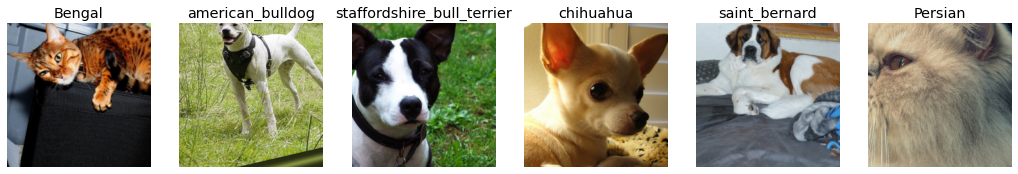

In [10]:
dls.show_batch(nrows=1, ncols=6)

Take a look at each image, and check that each one seems to have the correct label for that breed of pet. Often, data scientists work with data with which they are not as familiar as domain experts may be: for instance, I actually don't know what a lot of these pet breeds are. Since I am not an expert on pet breeds, I would use Google images at this point to search for a few of these breeds, and make sure the images look similar to what I see in this output.

If you made a mistake while building your `DataBlock`, it is very likely you won't see it before this step. To debug this, we encourage you to use the `summary` method. It will attempt to create a batch from the source you give it, with a lot of details. Also, if it fails, you will see exactly at which point the error happens, and the library will try to give you some help. For instance, one common mistake is to forget to use a `Resize` transform, so you end up with pictures of different sizes and are not able to batch them. Here is what the summary would look like in that case (note that the exact text may have changed since the time of writing, but it will give you an idea):

In [11]:
#hide_output
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
pets1.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/pomeranian_22.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x333
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/pomeranian_22.jpg
    applying partial gives
      pomeranian
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(28)

Final sample: (PILImage mode=RGB size=500x333, TensorCategory(28))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item

RuntimeError: ignored

```
Setting-up type transforms pipelines
Collecting items from /home/sgugger/.fastai/data/oxford-iiit-pet/images
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/sgugger/.fastai/data/oxford-iiit-pet/images/american_bulldog_83.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=375x500
  Pipeline: partial -> Categorize
    starting from
      /home/sgugger/.fastai/data/oxford-iiit-pet/images/american_bulldog_83.jpg
    applying partial gives
      american_bulldog
    applying Categorize gives
      TensorCategory(12)

Final sample: (PILImage mode=RGB size=375x500, TensorCategory(12))

Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: ToTensor
    starting from
      (PILImage mode=RGB size=375x500, TensorCategory(12))
    applying ToTensor gives
      (TensorImage of size 3x500x375, TensorCategory(12))

Adding the next 3 samples

No before_batch transform to apply

Collating items in a batch
Error! It's not possible to collate your items in a batch
Could not collate the 0-th members of your tuples because got the following 
shapes:
torch.Size([3, 500, 375]),torch.Size([3, 375, 500]),torch.Size([3, 333, 500]),
torch.Size([3, 375, 500])
```

You can see exactly how we gathered the data and split it, how we went from a filename to a *sample* (the tuple (image, category)), then what item transforms were applied and how it failed to collate those samples in a batch (because of the different shapes). 

Once you think your data looks right, we generally recommend the next step should be using it to train a simple model. We often see people put off the training of an actual model for far too long. As a result, they don't actually find out what their baseline results look like. Perhaps your problem doesn't need lots of fancy domain-specific engineering. Or perhaps the data doesn't seem to train the model at all. These are things that you want to know as soon as possible. For this initial test, we'll use the same simple model that we used in <<chapter_intro>>:

### Building the Model

In [12]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.534575,0.331197,0.101489,01:14


epoch,train_loss,valid_loss,error_rate,time
0,0.530651,0.313646,0.103518,01:14
1,0.335117,0.214190,0.072395,01:16


As we've briefly discussed before, the table shown when we fit a model shows us the results after each epoch of training. Remember, an epoch is one complete pass through all of the images in the data. The columns shown are the average loss over the items of the training set, the loss on the validation set, and any metrics that we requested—in this case, the error rate.

Remember that *loss* is whatever function we've decided to use to optimize the parameters of our model. But we haven't actually told fastai what loss function we want to use. So what is it doing? fastai will generally try to select an appropriate loss function based on what kind of data and model you are using. In this case we have image data and a categorical outcome, so fastai will default to using *cross-entropy loss*.

*Cross-entropy loss* is a loss function that is similar to the one we used in the previous chapter, but (as we'll see) has two benefits:

- It works even when our dependent variable has more than two categories.
- It results in faster and more reliable training.

### Viewing Predictions

Let's take a look at the activations of our model. To actually get a batch of real data from our `DataLoaders`, we can use the `one_batch` method:

In [13]:
x,y = dls.one_batch()

As you see, this returns the dependent and independent variables, as a mini-batch. Let's see what is actually contained in our dependent variable:

In [14]:
y

TensorCategory([21, 14, 34, 25, 18,  4, 11, 13, 27, 27, 13, 31, 29, 23, 11,  3,  3, 20,  6, 34, 31,  2, 12, 33, 14, 26, 13, 27, 35,  4, 10, 18, 13, 11,  7,  5, 14, 18, 19, 29, 28, 31,  4, 31, 26, 13,
                 5, 12, 29, 27, 20, 17, 12, 11,  9, 33, 22, 16, 28, 34,  9,  8, 33, 14], device='cuda:0')

Our batch size is 64, so we have 64 rows in this tensor. Each row is a single integer between 0 and 36, representing our 37 possible pet breeds. We can view the predictions (that is, the activations of the final layer of our neural network) using `Learner.get_preds`. This function either takes a dataset index (0 for train and 1 for valid) or an iterator of batches. Thus, we can pass it a simple list with our batch to get our predictions. It returns predictions and targets by default, but since we already have the targets, we can effectively ignore them by assigning to the special variable `_`:

In [15]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

TensorBase([3.6821e-07, 5.4421e-08, 5.2228e-07, 1.8406e-08, 5.8624e-08, 2.5262e-07, 1.9467e-06, 5.0355e-07, 3.5869e-07, 6.3618e-08, 4.2065e-08, 1.7676e-08, 6.3475e-06, 1.2660e-07, 1.3693e-06,
            7.6092e-08, 3.0985e-08, 4.8965e-08, 7.5751e-06, 3.8125e-05, 4.4660e-08, 9.9943e-01, 1.6936e-07, 7.9052e-07, 4.7691e-08, 8.2269e-05, 3.0712e-08, 9.2582e-05, 1.8137e-08, 5.5770e-09,
            1.6370e-04, 1.6668e-04, 9.6257e-09, 9.6831e-07, 2.6809e-08, 5.0701e-07, 6.8044e-09])

The actual predictions are 37 probabilities between 0 and 1, which add up to 1 in total:

In [16]:
len(preds[0]),preds[0].sum()

(37, TensorBase(1.))

## Model Interpretation

It's very hard to interpret loss functions directly, because they are designed to be things computers can differentiate and optimize, not things that people can understand. That's why we have metrics. These are not used in the optimization process, but just to help us poor humans understand what's going on. In this case, our accuracy is looking pretty good already! So where are we making mistakes?

We saw in <<chapter_intro>> that we can use a confusion matrix to see where our model is doing well, and where it's doing badly:

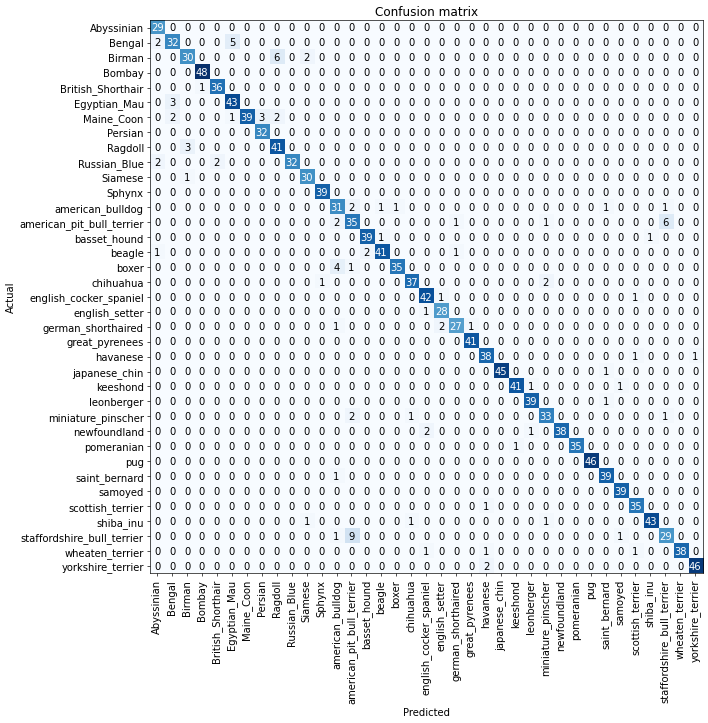

In [17]:
#width 600
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Oh dear—in this case, a confusion matrix is very hard to read. We have 37 different breeds of pet, which means we have 37×37 entries in this giant matrix! Instead, we can use the `most_confused` method, which just shows us the cells of the confusion matrix with the most incorrect predictions (here, with at least 5 or more):

In [18]:
interp.most_confused(min_val=5)

[('staffordshire_bull_terrier', 'american_pit_bull_terrier', 9),
 ('Birman', 'Ragdoll', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 5)]

Since we are not pet breed experts, it is hard for us to know whether these category errors reflect actual difficulties in recognizing breeds. So again, we turn to Google. A little bit of Googling tells us that the most common category errors shown here are actually breed differences that even expert breeders sometimes disagree about. So this gives us some comfort that we are on the right track.

We seem to have a good baseline. What can we do now to make it even better?

## Improving Our Model

We will now look at a range of techniques to improve the training of our model and make it better. While doing so, we will explain a little bit more about transfer learning and how to fine-tune our pretrained model as best as possible, without breaking the pretrained weights.

The first thing we need to set when training a model is the learning rate. We saw in the previous chapter that it needs to be just right to train as efficiently as possible, so how do we pick a good one? fastai provides a tool for this.

### The Learning Rate Finder

One of the most important things we can do when training a model is to make sure that we have the right learning rate. If our learning rate is too low, it can take many, many epochs to train our model. Not only does this waste time, but it also means that we may have problems with overfitting, because every time we do a complete pass through the data, we give our model a chance to memorize it.

So let's just make our learning rate really high, right? Sure, let's try that and see what happens:

In [19]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.651862,4.203529,0.418809,01:11


epoch,train_loss,valid_loss,error_rate,time
0,3.363046,1.939182,0.527740,01:17


That doesn't look good. Here's what happened. The optimizer stepped in the correct direction, but it stepped so far that it totally overshot the minimum loss. Repeating that multiple times makes it get further and further away, not closer and closer!

What do we do to find the perfect learning rate—not too high, and not too low? In 2015 the researcher **Leslie Smith** came up with a brilliant idea, called the *learning rate finder*. His idea was to start with a very, very small learning rate, something so small that we would never expect it to be too big to handle. We use that for one mini-batch, find what the losses are afterwards, and then increase the learning rate by some percentage (e.g., doubling it each time). Then we do another mini-batch, track the loss, and double the learning rate again. We keep doing this until the loss gets worse, instead of better. This is the point where we know we have gone too far. We then select a learning rate a bit lower than this point. Our advice is to pick either:

- One order of magnitude less than where the minimum loss was achieved (i.e., the minimum divided by 10)
- The last point where the loss was clearly decreasing 

The learning rate finder computes those points on the curve to help you. Both these rules usually give around the same value. In the first chapter, we didn't specify a learning rate, using the default value from the fastai library (which is 1e-3):

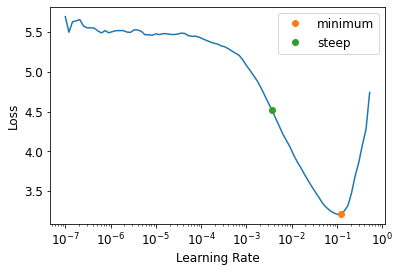

In [20]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [21]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.20e-02, steepest point: 3.63e-03


We can see on this plot that in the range 1e-6 to 1e-3, nothing really happens and the model doesn't train. Then the loss starts to decrease until it reaches a minimum, and then increases again. We don't want a learning rate greater than 1e-1 as it will give a training that diverges like the one before (you can try for yourself), but 1e-1 is already too high: at this stage we've left the period where the loss was decreasing steadily.

In this learning rate plot it appears that a learning rate around 3e-3 would be appropriate, so let's choose that:

In [22]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.334142,0.321975,0.096752,01:17


epoch,train_loss,valid_loss,error_rate,time
0,0.552231,0.383602,0.112991,01:16
1,0.348900,0.243870,0.072395,01:17


Now that we have a good learning rate to train our model, let's look at how we can fine-tune the weights of a pretrained model.

### Unfreezing and Transfer Learning

We discussed briefly in <<chapter_intro>> how transfer learning works. We saw that the basic idea is that a pretrained model, trained potentially on millions of data points (such as ImageNet), is fine-tuned for some other task. But what does this really mean?

We now know that a convolutional neural network consists of many linear layers with a nonlinear activation function between each pair, followed by one or more final linear layers with an activation function such as softmax at the very end. The final linear layer uses a matrix with enough columns such that the output size is the same as the number of classes in our model (assuming that we are doing classification).

This final linear layer is unlikely to be of any use for us when we are fine-tuning in a transfer learning setting, because it is specifically designed to classify the categories in the original pretraining dataset. So when we do transfer learning we remove it, throw it away, and replace it with a new linear layer with the correct number of outputs for our desired task (in this case, there would be 37 activations).

This newly added linear layer will have entirely random weights. Therefore, our model prior to fine-tuning has entirely random outputs. But that does not mean that it is an entirely random model! All of the layers prior to the last one have been carefully trained to be good at image classification tasks in general. As we saw in the images from the [Zeiler and Fergus paper](https://arxiv.org/pdf/1311.2901.pdf) in <<chapter_intro>> (see <<img_layer1>> through <<img_layer4>>), the first few layers encode very general concepts, such as finding gradients and edges, and later layers encode concepts that are still very useful for us, such as finding eyeballs and fur.

We want to train a model in such a way that we allow it to remember all of these generally useful ideas from the pretrained model, use them to solve our particular task (classify pet breeds), and only adjust them as required for the specifics of our particular task.

Our challenge when fine-tuning is to replace the random weights in our added linear layers with weights that correctly achieve our desired task (classifying pet breeds) without breaking the carefully pretrained weights and the other layers. There is actually a very simple trick to allow this to happen: tell the optimizer to only update the weights in those randomly added final layers. Don't change the weights in the rest of the neural network at all. This is called *freezing* those pretrained layers.

When we create a model from a pretrained network fastai automatically freezes all of the pretrained layers for us. When we call the `fine_tune` method fastai does two things:

- Trains the randomly added layers for one epoch, with all other layers frozen
- Unfreezes all of the layers, and trains them all for the number of epochs requested

Although this is a reasonable default approach, it is likely that for your particular dataset you may get better results by doing things slightly differently. The `fine_tune` method has a number of parameters you can use to change its behavior, but it might be easiest for you to just call the underlying methods directly if you want to get some custom behavior. Remember that you can see the source code for the method by using the following syntax:

    learn.fine_tune??

So let's try doing this manually ourselves. First of all we will train the randomly added layers for three epochs, using `fit_one_cycle`. As mentioned in <<chapter_intro>>, `fit_one_cycle` is the suggested way to train models without using `fine_tune`. In short, what `fit_one_cycle` does is to start training at a low learning rate, gradually increase it for the first section of training, and then gradually decrease it again for the last section of training.

In [23]:
learn.fine_tune??

In [24]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.133050,0.347901,0.110961,01:13
1,0.529589,0.232145,0.073072,01:11
2,0.319841,0.200197,0.068336,01:13


Then we'll unfreeze the model:

In [25]:
learn.unfreeze()

and run `lr_find` again, because having more layers to train, and weights that have already been trained for three epochs, means our previously found learning rate isn't appropriate any more:

SuggestedLRs(valley=5.248074739938602e-05)

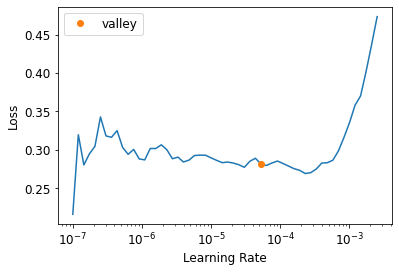

In [26]:
learn.lr_find()

Note that the graph is a little different from when we had random weights: we don't have that sharp descent that indicates the model is training. That's because our model has been trained already. Here we have a somewhat flat area before a sharp increase, and we should take a point well before that sharp increase—for instance, 1e-5. The point with the maximum gradient isn't what we look for here and should be ignored.

Let's train at a suitable learning rate:

In [27]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.248228,0.196361,0.066982,01:17
1,0.243059,0.192266,0.060893,01:16
2,0.232949,0.186003,0.059540,01:17
3,0.208627,0.183925,0.059540,01:16
4,0.205683,0.183457,0.060893,01:17
5,0.189913,0.182652,0.059540,01:17


This has improved our model a bit, but there's more we can do. The deepest layers of our pretrained model might not need as high a learning rate as the last ones, so we should probably use different learning rates for those—this is known as using *discriminative learning rates*.

### Discriminative Learning Rates

Even after we unfreeze, we still care a lot about the quality of those pretrained weights. We would not expect that the best learning rate for those pretrained parameters would be as high as for the randomly added parameters, even after we have tuned those randomly added parameters for a few epochs. Remember, the pretrained weights have been trained for hundreds of epochs, on millions of images.

In addition, do you remember the images we saw in <<chapter_intro>>, showing what each layer learns? The first layer learns very simple foundations, like edge and gradient detectors; these are likely to be just as useful for nearly any task. The later layers learn much more complex concepts, like "eye" and "sunset," which might not be useful in your task at all (maybe you're classifying car models, for instance). So it makes sense to let the later layers fine-tune more quickly than earlier layers.

Therefore, fastai's default approach is to use discriminative learning rates. This was originally developed in the ULMFiT approach to NLP transfer learning that we will introduce in <<chapter_nlp>>. Like many good ideas in deep learning, it is extremely simple: **use a lower learning rate for the early layers of the neural network, and a higher learning rate for the later layers (and especially the randomly added layers)**. The idea is based on insights developed by [Jason Yosinski](https://arxiv.org/abs/1411.1792), who showed in 2014 that with transfer learning different layers of a neural network should train at different speeds, as seen in <<yosinski>>.

<img alt="Impact of different layers and training methods on transfer learning (Yosinski)" width="680" caption="Impact of different layers and training methods on transfer learning (courtesy of Jason Yosinski et al.)" id="yosinski" src="https://github.com/fastai/fastbook/blob/master/images/att_00039.png?raw=1">

fastai lets you pass a Python `slice` object anywhere that a learning rate is expected. The first value passed will be the learning rate in the earliest layer of the neural network, and the second value will be the learning rate in the final layer. The layers in between will have learning rates that are multiplicatively equidistant throughout that range. Let's use this approach to replicate the previous training, but this time we'll only set the *lowest* layer of our net to a learning rate of 1e-6; the other layers will scale up to 1e-4. Let's train for a while and see what happens:

In [28]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.163231,0.338407,0.112991,01:11
1,0.535178,0.265664,0.075778,01:12
2,0.308380,0.216074,0.063599,01:13


epoch,train_loss,valid_loss,error_rate,time
0,0.261488,0.212942,0.062246,01:15
1,0.245779,0.206248,0.058863,01:17
2,0.240913,0.201023,0.062246,01:15
3,0.204224,0.199102,0.058863,01:16
4,0.193820,0.191522,0.054804,01:16
5,0.163503,0.194728,0.058863,01:15
6,0.161601,0.185683,0.056157,01:17
7,0.148166,0.192010,0.056834,01:15
8,0.145621,0.189973,0.053451,01:16
9,0.133846,0.188268,0.056834,01:16


Now the fine-tuning is working great!

fastai can show us a graph of the training and validation loss:

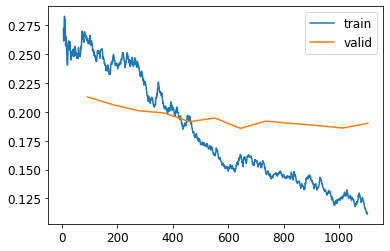

In [29]:
learn.recorder.plot_loss()

As you can see, the training loss keeps getting better and better. But notice that eventually the validation loss improvement slows, and sometimes even gets worse! This is the point at which the model is starting to over fit. In particular, the model is becoming overconfident of its predictions. But this does *not* mean that it is getting less accurate, necessarily. Take a look at the table of training results per epoch, and you will often see that the accuracy continues improving, even as the validation loss gets worse. In the end what matters is your accuracy, or more generally your chosen metrics, not the loss. The loss is just the function we've given the computer to help us to optimize.

Another decision you have to make when training the model is for how long to train for. We'll consider that next.

### Selecting the Number of Epochs

Often you will find that you are limited by time, rather than generalization and accuracy, when choosing how many epochs to train for. So your first approach to training should be to simply pick a number of epochs that will train in the amount of time that you are happy to wait for. Then look at the training and validation loss plots, as shown above, and in particular your metrics, and if you see that they are still getting better even in your final epochs, then you know that you have not trained for too long.

On the other hand, you may well see that the metrics you have chosen are really getting worse at the end of training. Remember, it's not just that we're looking for the validation loss to get worse, but the actual metrics. Your validation loss will first get worse during training because the model gets overconfident, and only later will get worse because it is incorrectly memorizing the data. We only care in practice about the latter issue. Remember, our loss function is just something that we use to allow our optimizer to have something it can differentiate and optimize; it's not actually the thing we care about in practice.

Before the days of 1cycle training it was very common to save the model at the end of each epoch, and then select whichever model had the best accuracy out of all of the models saved in each epoch. This is known as *early stopping*. However, this is very unlikely to give you the best answer, because those epochs in the middle occur before the learning rate has had a chance to reach the small values, where it can really find the best result. Therefore, if you find that you have overfit, what you should actually do is retrain your model from scratch, and this time select a total number of epochs based on where your previous best results were found.

If you have the time to train for more epochs, you may want to instead use that time to train more parameters—that is, use a deeper architecture.

### Deeper Architectures

In general, a model with more parameters can model your data more accurately. (There are lots and lots of caveats to this generalization, and it depends on the specifics of the architectures you are using, but it is a reasonable rule of thumb for now.) For most of the architectures that we will be seeing in this book, you can create larger versions of them by simply adding more layers. However, since we want to use pretrained models, we need to make sure that we choose a number of layers that have already been pretrained for us.

This is why, in practice, architectures tend to come in a small number of variants. For instance, the ResNet architecture that we are using in this chapter comes in variants with 18, 34, 50, 101, and 152 layer, pretrained on ImageNet. A larger (more layers and parameters; sometimes described as the "capacity" of a model) version of a ResNet will always be able to give us a better training loss, but it can suffer more from overfitting, because it has more parameters to overfit with.

In general, a bigger model has the ability to better capture the real underlying relationships in your data, and also to capture and memorize the specific details of your individual images.

However, using a deeper model is going to require more GPU RAM, so you may need to lower the size of your batches to avoid an *out-of-memory error*. This happens when you try to fit too much inside your GPU and looks like:

```
Cuda runtime error: out of memory
```

You may have to restart your notebook when this happens. The way to solve it is to use a smaller batch size, which means passing smaller groups of images at any given time through your model. You can pass the batch size you want to the call creating your `DataLoaders` with `bs=`.

The other downside of deeper architectures is that they take quite a bit longer to train. One technique that can speed things up a lot is *mixed-precision training*. This refers to using less-precise numbers (*half-precision floating point*, also called *fp16*) where possible during training. As we are writing these words in early 2020, nearly all current NVIDIA GPUs support a special feature called *tensor cores* that can dramatically speed up neural network training, by 2-3x. They also require a lot less GPU memory. To enable this feature in fastai, just add `to_fp16()` after your `Learner` creation (you also need to import the module).

You can't really know ahead of time what the best architecture for your particular problem is—you need to try training some. So let's try a ResNet-50 now with mixed precision:

In [30]:
from fastai.callback.fp16 import *
learn = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.264948,0.269474,0.081191,01:12
1,0.583541,0.289105,0.083221,01:08
2,0.443372,0.352466,0.102165,01:09


epoch,train_loss,valid_loss,error_rate,time
0,0.254704,0.248414,0.077131,01:10
1,0.301275,0.337333,0.087957,01:11
2,0.275604,0.252890,0.066306,01:12
3,0.157768,0.253110,0.073072,01:10
4,0.089194,0.216141,0.058187,01:12
5,0.055119,0.206217,0.057510,01:10


You'll see here we've gone back to using `fine_tune`, since it's so handy! We can pass `freeze_epochs` to tell fastai how many epochs to train for while frozen. It will automatically change learning rates appropriately for most datasets.

In this case, we're not seeing a clear win from the deeper model. This is useful to remember—bigger models aren't necessarily better models for your particular case! Make sure you try small models before you start scaling up.

## Conclusion

In this chapter you learned some important practical tips, both for getting your image data ready for modeling (presizing, data block summary) and for fitting the model (learning rate finder, unfreezing, discriminative learning rates, setting the number of epochs, and using deeper architectures). Using these tools will help you to build more accurate image models, more quickly.

